In [1]:
# cell 0 — runtime check (GPU expected: A100)
import os, platform, torch, psutil
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
print("Python:", platform.python_version())
print("CUDA available:", torch.cuda.is_available())
if not torch.cuda.is_available():
    raise SystemError("GPU not found. Set Runtime -> A100 GPU and re-run.")
print("GPU:", torch.cuda.get_device_name(0))
print("RAM GB:", round(psutil.virtual_memory().total/2**30, 2))

Python: 3.12.12
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
RAM GB: 167.05


In [2]:
# cell 1 — install deps
!pip -q install --upgrade transformers accelerate datasets sentencepiece huggingface_hub faiss-cpu
!pip -q install --upgrade vllm bitsandbytes || echo "Install note: vLLM/bitsandbytes fallback if unavailable."

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 55.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.2/438.2 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.0/180.0 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 12.9 MB/s eta 0

In [3]:
# cell 2 — clone repo + demo Wikipedia subset (~9 GB)
%cd /content
!git clone -q https://github.com/AkariAsai/self-rag.git
%cd /content/self-rag/retrieval_lm
!bash download_demo_corpus.sh
%cd /content

/content
/content/self-rag/retrieval_lm
Downloading...
From (original): https://drive.google.com/uc?id=1IYNAkwawfCDiBL27BlBqGssxFQH9vOux
From (redirected): https://drive.google.com/uc?id=1IYNAkwawfCDiBL27BlBqGssxFQH9vOux&confirm=t&uuid=690918ad-4856-465c-9e40-03c17342d1ce
To: /content/self-rag/retrieval_lm/enwiki_2020_intro_only.zip
100% 9.65G/9.65G [02:39<00:00, 60.4MB/s]
Archive:  enwiki_2020_intro_only.zip
   creating: enwiki_2020_intro_only/
   creating: enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/
  inflating: enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_03  
  inflating: enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_00  
  inflating: enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_02  
  inflating: enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_01  
  inflating: enwiki_2020_intro_only/enwiki_2020_dec_intro_only.jsonl  
/content


In [4]:
# cell 3 — retriever (CPU, FAISS)
%cd /content/self-rag/retrieval_lm
import os, sys
sys.path.insert(0, os.getcwd())  # make local 'src' importable
from passage_retrieval import Retriever

RETRIEVER_MODEL = "facebook/contriever-msmarco"
CORPUS_JSONL    = "enwiki_2020_intro_only/enwiki_2020_dec_intro_only.jsonl"
EMB_GLOB        = "enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/*"

retriever = Retriever({"device": "cpu"})  # keep VRAM for LLM
retriever.setup_retriever_demo(
    RETRIEVER_MODEL, CORPUS_JSONL, EMB_GLOB,
    n_docs=5, save_or_load_index=False
)

def retrieve_paragraphs(query, k=5, max_chars=1400):
    docs = retriever.search_document_demo(query, k)
    return [{"title": d["title"], "text": (d["text"] or "")[:max_chars]} for d in docs]

%cd /content

/content/self-rag/retrieval_lm
Loading model from: facebook/contriever-msmarco


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/contriever-msmarco were not used when initializing Contriever: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing Contriever from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Contriever from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Indexing passages from files ['enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_00', 'enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_01', 'enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_02', 'enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_03']
Loading file enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_00


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Total data indexed 1000000
Loading file enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_01
Total data indexed 2000000
Total data indexed 3000000
Loading file enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_02
Total data indexed 4000000
Loading file enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_03
Total data indexed 5000000
Total data indexed 6000000
Total data indexed 6088770
Data indexing completed.
Indexing time: 53.2 s.
loading passages
passages have been loaded
/content


In [5]:
# cell 4 — load SELF-RAG 7B via vLLM (clean)
import os
os.environ.setdefault("VLLM_WORKER_MULTIPROC_METHOD", "spawn")
os.environ.setdefault("VLLM_LOGGING_LEVEL", "WARNING")

from vllm import LLM, SamplingParams

MODEL_NAME = "selfrag/selfrag_llama2_7b"
llm = LLM(
    MODEL_NAME,
    dtype="half",
    tensor_parallel_size=1,
    gpu_memory_utilization=0.88,  # lower if VRAM is tight
    trust_remote_code=False,
)
sampling = SamplingParams(
    temperature=0.0, top_p=1.0, max_tokens=300, skip_special_tokens=False
)

def llm_generate(prompts):
    outs = llm.generate(prompts, sampling)
    return [o.outputs[0].text for o in outs]

print("Backend: vLLM fp16")

config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


WARNING 10-30 16:23:16 [model.py:1733] Casting torch.bfloat16 to torch.float16.


tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/470 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Backend: vLLM fp16


In [6]:
# cell 5 — prompt helpers
import re
def format_prompt(user_input, paragraph=None):
    p = f"### Instruction:\n{user_input}\n\n### Response:\n"
    if paragraph is not None:
        p += f"[Retrieval]<paragraph>{paragraph}</paragraph>"
    return p

_util_pat = re.compile(r"\[Utility:(\d)\]")
def best_by_utility(candidates):
    best, score = candidates[0], -1
    for c in candidates:
        m = _util_pat.search(c["output"])
        s = int(m.group(1)) if m else -1
        if s > score:
            best, score = c, s
    return best


In [7]:
# cell 6 — end-to-end ask() with on-demand retrieval over demo Wikipedia
def ask(query, k=5, show_docs=2):
    # Pass 1: see if model opts to retrieve
    first = llm_generate([format_prompt(query)])[0]
    needs = ("[Retrieval]" in first) or ("[Retrieve]" in first)
    print("First pass:\n", first.strip(), "\n")
    if not needs:
        return {"answer": first.strip(), "used_retrieval": False}

    # Retrieve and score candidates
    docs = retrieve_paragraphs(query, k=k)
    prompts = [format_prompt(query, f'{d["title"]}\n{d["text"]}') for d in docs]
    outs = llm_generate(prompts)
    cands = [{"doc": docs[i], "output": outs[i]} for i in range(len(docs))]
    best = best_by_utility(cands)

    print("Top evidence:")
    for d in docs[:show_docs]:
        print("-", d["title"])
    print("\nFinal answer:\n", best["output"].strip())
    return {
        "answer": best["output"].strip(),
        "used_retrieval": True,
        "evidence_titles": [d["title"] for d in docs]
    }


In [8]:
# cell 7 — test scaffolding helpers (non-invasive)
import textwrap as _tw

def _preview(text, n=300):
    t = (text or "").strip().replace("\n", " ")
    return (t[:n] + ("..." if len(t) > n else ""))

In [9]:
# cell 8 — quick KB checks
_docs = retrieve_paragraphs("machine learning", k=3)
print("KB sample titles:", [d["title"] for d in _docs])

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

Search time: 1.8 s.
KB sample titles: ['Machine learning', 'Machine Learning (journal)', 'Outline of machine learning']


In [10]:
# cell 9 — Self-Critique + Refinement Layer (Step 3 of SELF-RAG)
# Uses the SAME retriever (KB) for prompt construction.

import textwrap

def build_prompt(query: str, mode: str = "qa", retrieved_docs=None) -> str:
    """
    Construct prompt with retrieved KB context.
    """
    retrieved_docs = retrieved_docs or []
    ctx = "\n\n".join(
        [f"[TITLE] {d['title']}\n[TEXT]\n{d['text']}" for d in retrieved_docs]
    )
    header = {
        "qa": "Answer the question using ONLY the context. If missing, say: I don't know.",
        "compare_contrast": "Compare and contrast using ONLY the context.",
        "chain_of_thought": "Explain step-by-step using ONLY the context.",
        "explanatory": "Explain clearly using ONLY the context.",
    }.get(mode, "Answer using ONLY the context.")

    return textwrap.dedent(f"""
    ### System:
    {header}
    Cite titles when relevant.

    ### Context:
    {ctx if ctx else "[NO CONTEXT]"}

    ### Question:
    {query}

    ### Response:
    """)

def critique_prompt(query: str, initial_answer: str) -> str:
    """
    Build a meta-prompt asking the model to critique its own output.
    """
    return textwrap.dedent(f"""
    ### Instruction:
    You are a self-reflective AI assistant.
    The following is your *previous answer* to a user question.

    ---
    **Question:** {query}

    **Your previous answer:**
    {initial_answer}
    ---

    Please analyze your answer for:
    - Accuracy and factual correctness
    - Clarity and completeness
    - Possible reasoning errors or hallucinations

    Then provide:
    1. A short critique summary
    2. A refined final answer labeled **Final Answer:**

    ### Response:
    """)

def ask_with_prompt(query, mode="qa", k=5):
    """
    SELF-RAG retrieval + LLM with engineered prompt.
    Always retrieves from the SAME KB.
    """
    docs = retrieve_paragraphs(query, k=k)
    prompt = build_prompt(query, mode=mode, retrieved_docs=docs)
    output = llm_generate([prompt])[0]
    print(f"\nMode: {mode}\nQuery: {query}\n")
    print("Prompted output:\n", output)
    return {"answer": output, "used_mode": mode, "evidence_titles": [d["title"] for d in docs]}

def ask_with_reflection(query: str, mode: str = "qa", k: int = 5) -> dict:
    """
    Full SELF-RAG pipeline with reflection.
    Step 1: Generate base answer using KB-conditioned prompt
    Step 2: Critique and refine
    """
    print("\nSTEP 1 — Initial Generation\n")
    base = ask_with_prompt(query, mode=mode, k=k)
    initial_answer = base["answer"]

    print("\nSTEP 2 — Self-Critique + Refinement\n")
    critique_instruct = critique_prompt(query, initial_answer)
    refined_output = llm_generate([critique_instruct])[0]

    print("Critique & Final Response:\n")
    print(refined_output.strip())
    print("=" * 100 + "\n")

    return {
        "query": query,
        "initial_answer": initial_answer,
        "refined_output": refined_output.strip(),
        "mode": mode,
        "evidence_titles": base.get("evidence_titles", []),
    }

# Demo examples
# _ = ask_with_reflection("What is overfitting in machine learning?", mode="chain_of_thought")
# _ = ask_with_reflection("Compare supervised and unsupervised learning.", mode="compare_contrast")


In [11]:
# cell 10 — Confidence-Weighted Self-Selection Layer (robust evaluator)
# JSON-first judging with fallbacks. Works with current model outputs.

import json, re

def judge_prompt(query: str, candidates: list) -> str:
    """
    Ask the model to choose the better answer and return STRICT JSON.
    """
    joined = "\n\n".join([f"Answer {i+1}:\n{c}\n" for i, c in enumerate(candidates)])
    return f"""### Instruction:
You are a strict judge. Choose the better answer to the question.
Evaluate on: factual accuracy, completeness, clarity, reasoning.
Respond with ONLY a compact JSON object and nothing else.

### Question:
{query}

### Candidate Answers:
{joined}

### Required JSON schema:
{{"best": <1 or 2>, "scores": {{"1": <0-5>, "2": <0-5>}}, "rationale": "<one short sentence>"}}

### Response:
"""

def _extract_json_obj(text: str):
    for m in re.finditer(r"\{.*\}", text, re.DOTALL):
        frag = m.group(0)
        try:
            return json.loads(frag)
        except Exception:
            continue
    return None

def _extract_best_fallback(text: str):
    m = re.search(r"BEST\s*=\s*([12])", text, re.I)
    if m:
        return int(m.group(1))
    scores = {}
    m1 = re.search(r"[Ss]core\s*\(?1\)?\s*=\s*([0-5])", text)
    if m1:
        scores[1] = int(m1.group(1))
    m2 = re.search(r"[Ss]core\s*\(?2\)?\s*=\s*([0-5])", text)
    if m2:
        scores[2] = int(m2.group(1))
    if scores:
        return max(scores, key=scores.get)
    return None

def select_best_answer(query: str, initial_answer: str, refined_answer: str):
    """
    Judge two answers and pick the best using robust parsing.
    Defaults to refined_answer if parsing fails.
    """
    prompt = judge_prompt(query, [initial_answer, refined_answer])
    result = llm_generate([prompt])[0]

    best_idx = None
    obj = _extract_json_obj(result)
    if isinstance(obj, dict):
        if obj.get("best") in (1, 2):
            best_idx = obj["best"]
        elif str(obj.get("best")) in {"1", "2"}:
            best_idx = int(obj["best"])
    if best_idx not in (1, 2):
        best_idx = _extract_best_fallback(result)
    if best_idx not in (1, 2):
        best_idx = 2  # conservative default

    final_answer = [initial_answer, refined_answer][best_idx - 1]

    print("\nEvaluation Output (raw):\n", result)
    print(f"Selected Answer: #{best_idx}\n")
    return final_answer

def ask_full_selfrag(query: str, mode: str = "qa", k: int = 5):
    """
    Complete SELF-RAG pipeline:
      Generate with KB → Critique → Judge and select best.
    """
    result = ask_with_reflection(query, mode=mode, k=k)
    best = select_best_answer(query, result["initial_answer"], result["refined_output"])
    return {"query": query, "best_answer": best, **result}

# Demo
# _ = ask_full_selfrag("What is overfitting in machine learning?", mode="chain_of_thought")
# _ = ask_full_selfrag("Compare supervised and unsupervised learning.", mode="compare_contrast")


In [12]:
# cell 11 — Compare Baseline vs Prompt-Engineered SELF-RAG + persist results (with evaluation metadata)
from textwrap import shorten
from datetime import datetime
from pathlib import Path
import pandas as pd
import json, re

def _looks_grounded(text: str, docs) -> bool:
    if not isinstance(text, str) or len(re.sub(r"\W+", "", text)) < 30:
        return False
    t_low = text.lower()
    if any((d.get("title") or "").lower() in t_low for d in docs if d.get("title")):
        return True
    ctx = " ".join((d.get("text") or "")[:400] for d in docs).lower()
    ctx_words = {w for w in re.findall(r"[a-z]{7,}", ctx)}
    ans_words = {w for w in re.findall(r"[a-z]{7,}", t_low)}
    return len(ctx_words.intersection(ans_words)) >= 2

def run_baseline(query: str, k: int = 5):
    """
    Grounded baseline: aggregate KB context, enforce citations or 'I don't know'.
    """
    docs = retrieve_paragraphs(query, k=k)
    prompt = build_prompt(query, mode="qa", retrieved_docs=docs)
    out = llm_generate([prompt])[0].strip()
    if not _looks_grounded(out, docs):
        strict = (
            prompt
            + "\n\nStrict rules: Use ONLY the Context. "
              "Cite at least one [TITLE] from Context. "
              "If the Context is insufficient, answer exactly: I don't know."
        )
        out2 = llm_generate([strict])[0].strip()
        if _looks_grounded(out2, docs):
            out = out2
    return {
        "answer": out,
        "used_retrieval": True,
        "evidence_titles": [d["title"] for d in docs],
    }

def _to_int_or_none(x):
    return int(x) if isinstance(x, (int, str)) and str(x).isdigit() else None

def _eval_pair(query: str, base_text: str, enh_text: str):
    """
    Run judge on baseline vs enhanced and parse results.
    Returns dict with eval_best, eval_score_1, eval_score_2, eval_rationale, eval_raw.
    """
    jp = judge_prompt(query, [base_text, enh_text])
    raw = llm_generate([jp])[0]

    obj = _extract_json_obj(raw) or {}
    # best
    best = obj.get("best")
    if best not in (1, 2):
        try:
            best = int(best)
        except Exception:
            best = None
    if best not in (1, 2):
        best = _extract_best_fallback(raw)

    # scores
    s1 = s2 = None
    scores = obj.get("scores") if isinstance(obj, dict) else None
    if isinstance(scores, dict):
        s1 = _to_int_or_none(scores.get("1"))
        s2 = _to_int_or_none(scores.get("2"))
    if s1 is None or s2 is None:
        m1 = re.search(r"[Ss]core\s*\(?1\)?\s*=\s*([0-5])", raw)
        m2 = re.search(r"[Ss]core\s*\(?2\)?\s*=\s*([0-5])", raw)
        s1 = s1 if s1 is not None else (_to_int_or_none(m1.group(1)) if m1 else None)
        s2 = s2 if s2 is not None else (_to_int_or_none(m2.group(1)) if m2 else None)

    rationale = obj.get("rationale") if isinstance(obj, dict) else None
    if not isinstance(rationale, str):
        rationale = ""

    return {
        "eval_best": int(best) if best in (1, 2) else None,
        "eval_score_1": s1,
        "eval_score_2": s2,
        "eval_rationale": rationale.strip(),
        "eval_raw": raw,
    }

def compare_before_after(query: str, mode="qa", k=5):
    """
    Compare grounded baseline vs enhanced SELF-RAG and include evaluation metadata.
    """
    print("\n" + "=" * 120)
    print(f"Query: {query}")
    print("=" * 120 + "\n")

    # Baseline
    print("BASELINE: Grounded single-pass with KB context\n")
    base = run_baseline(query, k=k)
    base_ans = base["answer"].strip()
    print(shorten(base_ans, width=800, placeholder="..."))
    print("\n" + "-" * 120 + "\n")

    # Enhanced
    print("ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG\n")
    enhanced = ask_full_selfrag(query, mode=mode, k=k)
    enhanced_ans = enhanced["best_answer"].strip()
    print(shorten(enhanced_ans, width=800, placeholder="..."))
    print("\n" + "=" * 120 + "\n")

    # Evaluation metadata for reproducibility
    eval_meta = _eval_pair(query, base_ans, enhanced_ans)

    return {
        "baseline": base_ans,
        "enhanced": enhanced_ans,
        "mode": mode,
        **eval_meta,
    }

# Diverse tests
TEST_QUERIES = [
    ("What is the difference between precision and recall in machine learning?", "compare_contrast"),
    ("Explain why the sky appears blue using physics concepts.", "explanatory"),
    # ("How does gradient descent minimize a loss function?", "chain_of_thought"),
    ("Who won the Nobel Prize in Physics in 2023 and for what?", "qa"),
    ("What are Large Language Models and how do they differ from traditional NLP models?", "explanatory"),
    ("Explain quantum entanglement as if I were 10 years old.", "explanatory"),
    # ("How would you detect bias in a machine learning model?", "chain_of_thought"),
    ("What are the key differences between supervised, unsupervised, and reinforcement learning?", "compare_contrast"),
    ("Explain the concept of transformers in deep learning architecture.", "explanatory"),
    ("Describe the impact of AI on climate change research.", "qa"),
]

results = []
for i, (query, mode) in enumerate(TEST_QUERIES, start=1):
    print(f"\n\nTEST {i}/{len(TEST_QUERIES)} — {query}\n")
    res = compare_before_after(query, mode=mode)
    results.append({"index": i, "query": query, **res})

# ---------- Persist with evaluation metadata ----------
cols = [
    "index", "query", "mode",
    "baseline", "enhanced",
    "eval_best", "eval_score_1", "eval_score_2", "eval_rationale"
]
results_df = pd.DataFrame(results, columns=cols).set_index("index")

print("\nSummary table:")
print(results_df.assign(
    baseline_preview=results_df["baseline"].str.slice(0, 120),
    enhanced_preview=results_df["enhanced"].str.slice(0, 120)
)[["query", "mode", "eval_best", "eval_score_1", "eval_score_2",
   "baseline_preview", "enhanced_preview"]])

ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
out_dir = Path("./selfrag_runs"); out_dir.mkdir(parents=True, exist_ok=True)
json_path = out_dir / f"eval_results_{ts}.json"
csv_path  = out_dir / f"eval_results_{ts}.csv"

# CSV: structured columns (no raw text blob)
results_df.to_csv(csv_path)

# JSON: include full raw judge output per test for reproducibility
with open(json_path, "w", encoding="utf-8") as f:
    json.dump({"timestamp_utc": ts, "tests": results}, f, ensure_ascii=False, indent=2)

print(f"\nSaved results:\n- Local CSV:  {csv_path}\n- Local JSON: {json_path}")
LAST_RESULTS_CSV  = str(csv_path)
LAST_RESULTS_JSON = str(json_path)




TEST 1/8 — What is the difference between precision and recall in machine learning?


Query: What is the difference between precision and recall in machine learning?

BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

1.[Continue to Use Evidence]Precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances. 2.[Continue to Use Evidence]Recall (also known as sensitivity) is the fraction of relevant instances that were retrieved. 3.[Continue to Use Evidence]Both precision and recall are therefore based on relevance. 4.[Continue to Use Evidence]Precision and recall are performance metrics that apply to data retrieved from a collection, corpus or sample space. 5.[Continue to Use Evidence]Precision and recall are used in pattern recognition, information retrieval and classification (machine learning). 6.[Continue to Use Evidence]Precision and recall are important metrics to consider when evaluating the performance of a machine learning model.[Utility:5]

------------------------------------------------------------------------------------------------------------------------

ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


STEP 1 — Initial Gen

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Mode: compare_contrast
Query: What is the difference between precision and recall in machine learning?

Prompted output:
 1.[Continue to Use Evidence]Precision is the fraction of relevant instances among the retrieved instances.
2.[Continue to Use Evidence]Recall is the fraction of relevant instances that were retrieved.
3.[Continue to Use Evidence]Both precision and recall are based on relevance.
4.[Continue to Use Evidence]Precision is also called positive predictive value.
5.[Continue to Use Evidence]Recall is also known as sensitivity.
6.[Continue to Use Evidence]Precision and recall are performance metrics that apply to data retrieved from a collection, corpus, or sample space.
7.[Continue to Use Evidence]Instance-based learning is a family of learning algorithms that compare new problem instances with instances seen in training.
8.[Continue to Use Evidence]Remembering and knowing represent relatively different characteristics of memory.
9.[Continue to Use Evidence]Accuracy is no

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Critique & Final Response:

1.[No Retrieval]Accuracy and factual correctness:
The answer is factually correct and accurate.
2.[No Retrieval]Clarity and completeness:
The answer is clear and complete.
3.[No Retrieval]Reasoning errors or hallucinations:
There are no reasoning errors or hallucinations in the answer.
1.[No Retrieval]Critique summary:
The answer is factually correct and accurate.[No Retrieval]2. Final answer:

**Final Answer:**

Precision and recall are performance metrics that apply to data retrieved from a collection, corpus, or sample space.[Continue to Use Evidence]Precision is also called positive predictive value, and recall is also known as sensitivity.[Continue to Use Evidence]Both precision and recall are based on relevance, and instance-based learning is a family of learning algorithms that compare new problem instances with instances seen in training.[Continue to Use Evidence]Remembering and knowing represent relatively different characteristics of memory.[Contin

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Evaluation Output (raw):
 {
"best": 2,
"scores": {
"1": 5,
"2": 5
},
"rationale": "The answer is factually correct and accurate.[No Retrieval]It is clear and complete, and there are no reasoning errors or hallucinations.[No Retrieval]Therefore, precision and recall are better measures in such cases, and accuracy is not a good metric for predictive models when classifying in predictive analytics."
}[Utility:5]
Selected Answer: #2

1.[No Retrieval]Accuracy and factual correctness: The answer is factually correct and accurate. 2.[No Retrieval]Clarity and completeness: The answer is clear and complete. 3.[No Retrieval]Reasoning errors or hallucinations: There are no reasoning errors or hallucinations in the answer. 1.[No Retrieval]Critique summary: The answer is factually correct and accurate.[No Retrieval]2. Final answer: **Final Answer:** Precision and recall are performance metrics that apply to data retrieved from a collection, corpus, or sample space.[Continue to Use Evidence]Precisi

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]



TEST 2/8 — Explain why the sky appears blue using physics concepts.


Query: Explain why the sky appears blue using physics concepts.

BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

1.[Retrieval]<paragraph>[Irrelevant]The blue color of the sky is due to the scattering of sunlight by particles in the atmosphere, such as water droplets, dust, and air molecules.[Continue to Use Evidence]This scattering causes the sky to appear blue because blue light is scattered more than other colors of light.[Continue to Use Evidence]This is why the sky appears blue during the day.[Utility:5]

------------------------------------------------------------------------------------------------------------------------

ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


STEP 1 — Initial Generation

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Mode: explanatory
Query: Explain why the sky appears blue using physics concepts.

Prompted output:
 1.[Retrieval]<paragraph>[Irrelevant]The blue color of the sky is due to the scattering of sunlight by particles in the atmosphere, such as water vapor, dust, and aerosols.[Continue to Use Evidence]This scattering causes the sky to appear blue because blue light is scattered more than other colors of light.[Continue to Use Evidence]This is why the sky appears blue during the day.[Utility:5]

STEP 2 — Self-Critique + Refinement



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Critique & Final Response:

Accuracy and factual correctness:
The answer is accurate and factually correct.[Continue to Use Evidence]It explains the physics concept behind why the sky appears blue, which is due to the scattering of sunlight by particles in the atmosphere.

Clarity and completeness:
The answer is clear and complete.[Continue to Use Evidence]It provides a concise explanation of the physics concept and the reasoning behind it.[No Retrieval]Possible reasoning errors or hallucinations:
There are no possible reasoning errors or hallucinations in the previous answer.[No Retrieval]Critique summary:
The previous answer is accurate and factually correct, clear and complete, and free from reasoning errors or hallucinations.[No Retrieval]Final answer:
The sky appears blue due to the scattering of sunlight by particles in the atmosphere, such as water vapor, dust, and aerosols.[Utility:5]



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Evaluation Output (raw):
 {
"best": 2,
"scores": {
"1": 5,
"2": 5
},
"rationale": "The answer is clear and complete.[No Retrieval]It provides a concise explanation of the physics concept and the reasoning behind it."
}[Utility:5]
Selected Answer: #2

Accuracy and factual correctness: The answer is accurate and factually correct.[Continue to Use Evidence]It explains the physics concept behind why the sky appears blue, which is due to the scattering of sunlight by particles in the atmosphere. Clarity and completeness: The answer is clear and complete.[Continue to Use Evidence]It provides a concise explanation of the physics concept and the reasoning behind it.[No Retrieval]Possible reasoning errors or hallucinations: There are no possible reasoning errors or hallucinations in the previous answer.[No Retrieval]Critique summary: The previous answer is accurate and factually correct, clear and complete, and free from reasoning errors or hallucinations.[No Retrieval]Final answer: The sky ap

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]



TEST 3/8 — Who won the Nobel Prize in Physics in 2023 and for what?


Query: Who won the Nobel Prize in Physics in 2023 and for what?

BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

I don't know.[Utility:5]

------------------------------------------------------------------------------------------------------------------------

ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


STEP 1 — Initial Generation

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Mode: qa
Query: Who won the Nobel Prize in Physics in 2023 and for what?

Prompted output:
 I don't know.[Utility:5]

STEP 2 — Self-Critique + Refinement



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Critique & Final Response:

1.Critique summary:
The AI assistant's previous answer was inaccurate and factually incorrect.[No Retrieval]The Nobel Prize in Physics for 2023 has not yet been awarded, and the AI assistant did not provide any information about the winner or the award.[No Retrieval]2. Final answer: "The Nobel Prize in Physics for 2023 has not yet been awarded, and the AI assistant did not provide any information about the winner or the award."[Utility:5]



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Evaluation Output (raw):
 {
"best": 2,
"scores": {
"1": 0,
"2": 5
},
"rationale": "Answer 1 is inaccurate and factually incorrect."
}[Utility:5]
Selected Answer: #2

1.Critique summary: The AI assistant's previous answer was inaccurate and factually incorrect.[No Retrieval]The Nobel Prize in Physics for 2023 has not yet been awarded, and the AI assistant did not provide any information about the winner or the award.[No Retrieval]2. Final answer: "The Nobel Prize in Physics for 2023 has not yet been awarded, and the AI assistant did not provide any information about the winner or the award."[Utility:5]




Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]



TEST 4/8 — What are Large Language Models and how do they differ from traditional NLP models?


Query: What are Large Language Models and how do they differ from traditional NLP models?

BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Large Language Models (LLMs) are a type of artificial intelligence (AI) model that is trained on large amounts of text data to generate human-like language.[Retrieval]<paragraph>[Relevant]They differ from traditional NLP models in several ways: 1.[No support / Contradictory]2.3.4.5.[Utility:5]

------------------------------------------------------------------------------------------------------------------------

ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


STEP 1 — Initial Generation

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Mode: explanatory
Query: What are Large Language Models and how do they differ from traditional NLP models?

Prompted output:
 Large Language Models (LLMs) are a type of artificial intelligence (AI) model that is trained on large amounts of text data to generate human-like language.[Retrieval]<paragraph>[Relevant]LLMs differ from traditional NLP models in several ways.[No support / Contradictory][Continue to Use Evidence]LLMs are trained on large amounts of text data, while traditional NLP models are typically trained on smaller datasets.[Retrieval]<paragraph>[Utility:5]

STEP 2 — Self-Critique + Refinement



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Critique & Final Response:

**Critique summary:**
The previous answer provides a basic overview of LLMs and their differences from traditional NLP models.[No Retrieval]However, it could be improved by providing more specific details about the differences between LLMs and traditional NLP models, such as the size of the datasets used for training and the specific techniques used for training LLMs.[No Retrieval]Additionally, the answer could be refined by providing more specific examples of LLMs and their applications.[No Retrieval]**Final answer:**
Large Language Models (LLMs) are a type of artificial intelligence (AI) model that is trained on large amounts of text data to generate human-like language.[Continue to Use Evidence]LLMs differ from traditional NLP models in several ways.[Continue to Use Evidence]LLMs are trained on large amounts of text data, while traditional NLP models are typically trained on smaller datasets.[Continue to Use Evidence]LLMs also differ from traditional NLP 

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Evaluation Output (raw):
 {
"best": 2,
"scores": {
"1": 4,
"2": 5
},
"rationale": "Answer 2 provides more specific details about the differences between LLMs and traditional NLP models, such as the size of the datasets used for training and the specific techniques used for training LLMs.[No Retrieval]It also provides more specific examples of LLMs and their applications."
}[Utility:5]
Selected Answer: #2

**Critique summary:** The previous answer provides a basic overview of LLMs and their differences from traditional NLP models.[No Retrieval]However, it could be improved by providing more specific details about the differences between LLMs and traditional NLP models, such as the size of the datasets used for training and the specific techniques used for training LLMs.[No Retrieval]Additionally, the answer could be refined by providing more specific examples of LLMs and their applications.[No Retrieval]**Final answer:** Large Language Models (LLMs) are a type of artificial intelligenc

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]



TEST 5/8 — Explain quantum entanglement as if I were 10 years old.


Query: Explain quantum entanglement as if I were 10 years old.

BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Sure![No Retrieval]Imagine that you have a bunch of toy cars.[No Retrieval]You can put them in different colors and shapes, but they are still just toy cars.[No Retrieval]Now, imagine that you have two toy cars that are connected together.[Retrieval]<paragraph> Answer the question using ONLY the context.[No Retrieval]If missing, say: I don't know.[No Retrieval]Cite titles when relevant. [TITLE] Quantum entanglement [TEXT] Quantum entanglement is a physical phenomenon that occurs when a group of particles are generated, interact, or share spatial proximity in a way such that the quantum state of each particle of the group cannot be described independently of the state of the others, including when the particles are separated by a large distance.[No Retrieval]The topic of quantum...

------------------------------------------------------------------------------------------------------------------------

ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


STEP 1 — Initial Generation


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Mode: explanatory
Query: Explain quantum entanglement as if I were 10 years old.

Prompted output:
 Sure![Retrieval]<paragraph>[Irrelevant][TITLE] Quantum entanglement
[TEXT]
  Quantum entanglement is a physical phenomenon that occurs when a group of particles are generated, interact, or share spatial proximity in a way such that the quantum state of each particle of the group cannot be described independently of the state of the others, including when the particles are separated by a large distance.[Continue to Use Evidence]It's like when you and your best friend share a secret code that only the two of you know.[No Retrieval]When you're apart, your secret code can still be used to communicate with each other, even if you're on opposite sides of the world.[No Retrieval]That's what quantum entanglement is like for particles.[Utility:5]

STEP 2 — Self-Critique + Refinement



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Critique & Final Response:

1.Critique summary:[No Retrieval]The previous answer is accurate and factually correct, but it could be more clear and complete.[No Retrieval]It does not mention the key concept of quantum entanglement, which is the ability of particles to interact and share information even when they are separated by a large distance.[No Retrieval]2. Final answer:

Quantum entanglement is a phenomenon where particles can interact and share information even when they are separated by a large distance.[Continue to Use Evidence]It's like when you and your best friend share a secret code that only the two of you know.[No Retrieval]When you're apart, your secret code can still be used to communicate with each other, even if you're on opposite sides of the world.[Utility:5]



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Evaluation Output (raw):
 {
"best": 2,
"scores": {
"1": 4,
"2": 5
},
"rationale": "2 answer is more complete and clearer"
}[Utility:5]
Selected Answer: #2

1.Critique summary:[No Retrieval]The previous answer is accurate and factually correct, but it could be more clear and complete.[No Retrieval]It does not mention the key concept of quantum entanglement, which is the ability of particles to interact and share information even when they are separated by a large distance.[No Retrieval]2. Final answer: Quantum entanglement is a phenomenon where particles can interact and share information even when they are separated by a large distance.[Continue to Use Evidence]It's like when you and your best friend share a secret code that only the two of you know.[No Retrieval]When you're apart, your secret code can still be used to communicate with each other, even if you're on opposite sides of the world.[Utility:5]




Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]



TEST 6/8 — What are the key differences between supervised, unsupervised, and reinforcement learning?


Query: What are the key differences between supervised, unsupervised, and reinforcement learning?

BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

1.[Retrieval]<paragraph>[Irrelevant]Input: [TITLE] Supervised learning [TEXT] Supervised learning (SL) is the machine learning task of learning a function that maps an input to an output based on example input-output pairs.[Continue to Use Evidence]It infers a function from labeled training data consisting of a set of training examples.[Continue to Use Evidence]In supervised learning, each example is a pair consisting of an input object (typically a vector) and a desired output value (also called the supervisory signal).[Continue to Use Evidence]A supervised learning algorithm analyzes the training data and produces an inferred function, which can be used for mapping new examples.[Continue to Use Evidence]An optimal scenario will allow for the algorithm to correctly determine the class...

------------------------------------------------------------------------------------------------------------------------

ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


STEP 1 — Initial Gen

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Mode: compare_contrast
Query: What are the key differences between supervised, unsupervised, and reinforcement learning?

Prompted output:
 1.2.3.[Utility:5]

STEP 2 — Self-Critique + Refinement



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Critique & Final Response:

1.Critique summary:[No Retrieval]The previous answer provided a brief overview of the key differences between supervised, unsupervised, and reinforcement learning, but it could be improved in terms of accuracy and factual correctness.
2.Final answer:[Retrieval]<paragraph>I'm sorry, but I don't understand what you mean by "hallucinations".[No Retrieval]Could you please provide more context or clarify your question?[Utility:4]



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Evaluation Output (raw):
 {
"best": 2,
"scores": {
"1": 4,
"2": 5
},
"rationale": "Answer 2 provides a more detailed and accurate explanation of the key differences between supervised, unsupervised, and reinforcement learning."
}[Utility:5]
Selected Answer: #2

1.Critique summary:[No Retrieval]The previous answer provided a brief overview of the key differences between supervised, unsupervised, and reinforcement learning, but it could be improved in terms of accuracy and factual correctness. 2.Final answer:[Retrieval]<paragraph>I'm sorry, but I don't understand what you mean by "hallucinations".[No Retrieval]Could you please provide more context or clarify your question?[Utility:4]




Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]



TEST 7/8 — Explain the concept of transformers in deep learning architecture.


Query: Explain the concept of transformers in deep learning architecture.

BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Transformers are a type of deep learning model that uses self-attention mechanisms to process sequential data such as natural language processing (NLP) and computer vision (CV).[Continue to Use Evidence]They do not necessarily process data in order, but rather use attention mechanisms to provide context to any position in the input sequence.[Retrieval]<paragraph>[Irrelevant]Transformers are a type of deep learning model that uses self-attention mechanisms to process sequential data such as natural language processing (NLP) and computer vision (CV).[Continue to Use Evidence]They do not necessarily process data in order, but rather use attention mechanisms to provide context to any position in the input sequence.[Continue to Use Evidence]Transformers are primarily used in NLP and CV, and...

------------------------------------------------------------------------------------------------------------------------

ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


STEP 1 — Initial Gen

100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Mode: explanatory
Query: Explain the concept of transformers in deep learning architecture.

Prompted output:
 Sure![Retrieval]<paragraph>[Irrelevant][TITLE] Transformer (machine learning model)
[TEXT]
 A transformer is a deep learning model that adopts the mechanism of self-attention, differentially weighting the significance of each part of the input data.[Continue to Use Evidence]It is used primarily in the field of natural language processing (NLP) and in computer vision (CV).[Continue to Use Evidence]Like recurrent neural networks (RNNs), transformers are designed to handle sequential input data, such as natural language, for tasks such as translation and text summarization.[Continue to Use Evidence]However, unlike RNNs, transformers do not necessarily process the data in order.[Continue to Use Evidence]Rather, the attention mechanism provides context for any position in the input sequence.[Continue to Use Evidence]For example, if the input data is a natural language sentence, th

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Critique & Final Response:

1.Critique summary:[No Retrieval]The previous answer provided a basic overview of the concept of transformers in deep learning architecture, but it could be improved in terms of accuracy and completeness.
2.Final answer:
Transformers are a type of deep learning architecture that are used for natural language processing tasks such as translation and text summarization.[Continue to Use Evidence]They differ from recurrent neural networks (RNNs) in that they do not necessarily process the data in order, instead using the attention mechanism to provide context for any position in the input sequence.[Continue to Use Evidence]The previous answer could be refined by providing more specific examples of how transformers are used in natural language processing tasks, as well as discussing their limitations and potential drawbacks.[Utility:5]



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Evaluation Output (raw):
 {
"best": 2,
"scores": {
"1": 3,
"2": 4
},
"rationale": "The previous answer provided a basic overview of the concept of transformers in deep learning architecture, but it could be improved in terms of accuracy and completeness."
}[Utility:5]
Selected Answer: #2

1.Critique summary:[No Retrieval]The previous answer provided a basic overview of the concept of transformers in deep learning architecture, but it could be improved in terms of accuracy and completeness. 2.Final answer: Transformers are a type of deep learning architecture that are used for natural language processing tasks such as translation and text summarization.[Continue to Use Evidence]They differ from recurrent neural networks (RNNs) in that they do not necessarily process the data in order, instead using the attention mechanism to provide context for any position in the input sequence.[Continue to Use Evidence]The previous answer could be refined by providing more specific examples of how tr

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]



TEST 8/8 — Describe the impact of AI on climate change research.


Query: Describe the impact of AI on climate change research.

BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

1.[Retrieval]<paragraph>[Irrelevant]AI can be used to analyze large datasets, identify patterns, and make predictions about climate change. 2.[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Utility:5]

------------------------------------------------------------------------------------------------------------------------

ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


STEP 1 — Initial Generation

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Mode: qa
Query: Describe the impact of AI on climate change research.

Prompted output:
 1.[Retrieval]<paragraph>[Irrelevant]AI can be used to analyze large datasets, identify patterns, and make predictions about climate change.
2.[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Retrieval]<paragraph>[Utility:5]

STEP 2 — Self-Critique + Refinement



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Critique & Final Response:

1.[Continue to Use Evidence]AI can help to improve the accuracy and speed of climate change research by analyzing large datasets, identifying patterns, and making predictions.
2.[Continue to Use Evidence]AI can help to identify new areas of research and develop new methods for studying climate change.
3.[Continue to Use Evidence]AI can help to improve the accuracy of climate models and help to better understand the impact of climate change on different regions of the world.
4.[Continue to Use Evidence]AI can help to identify new ways to reduce greenhouse gas emissions and mitigate the effects of climate change.
5.[Continue to Use Evidence]AI can help to improve the accuracy of climate change predictions and help to better understand the impact of climate change on different regions of the world.[Utility:5]



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Evaluation Output (raw):
 {
"best": 2,
"scores": {
"1": 4,
"2": 5
},
"rationale": "Answer 2 provides more detailed information on the impact of AI on climate change research, including how it can help to improve accuracy, identify new areas of research, and develop new methods for studying climate change.[No Retrieval]Answer 1 is more general and does not provide as much detail."[Utility:5]
Selected Answer: #2

1.[Continue to Use Evidence]AI can help to improve the accuracy and speed of climate change research by analyzing large datasets, identifying patterns, and making predictions. 2.[Continue to Use Evidence]AI can help to identify new areas of research and develop new methods for studying climate change. 3.[Continue to Use Evidence]AI can help to improve the accuracy of climate models and help to better understand the impact of climate change on different regions of the world. 4.[Continue to Use Evidence]AI can help to identify new ways to reduce greenhouse gas emissions and mitig

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Summary table:
                                                   query              mode  \
index                                                                        
1      What is the difference between precision and r...  compare_contrast   
2      Explain why the sky appears blue using physics...       explanatory   
3      Who won the Nobel Prize in Physics in 2023 and...                qa   
4      What are Large Language Models and how do they...       explanatory   
5      Explain quantum entanglement as if I were 10 y...       explanatory   
6      What are the key differences between supervise...  compare_contrast   
7      Explain the concept of transformers in deep le...       explanatory   
8      Describe the impact of AI on climate change re...                qa   

       eval_best  eval_score_1  eval_score_2  \
index                                          
1            2.0           5.0           5.0   
2            2.0           5.0           5.0   
3          

/tmp/ipython-input-889714687.py:155: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


Loaded from: selfrag_runs/eval_results_20251030T162640Z.csv
                                                   query              mode  \
index                                                                        
1      What is the difference between precision and r...  compare_contrast   
2      Explain why the sky appears blue using physics...       explanatory   
3      Who won the Nobel Prize in Physics in 2023 and...                qa   
4      What are Large Language Models and how do they...       explanatory   
5      Explain quantum entanglement as if I were 10 y...       explanatory   
6      What are the key differences between supervise...  compare_contrast   
7      Explain the concept of transformers in deep le...       explanatory   
8      Describe the impact of AI on climate change re...                qa   

       baseline_score  enhanced_score  
index                                  
1                   5               5  
2                   5               5  

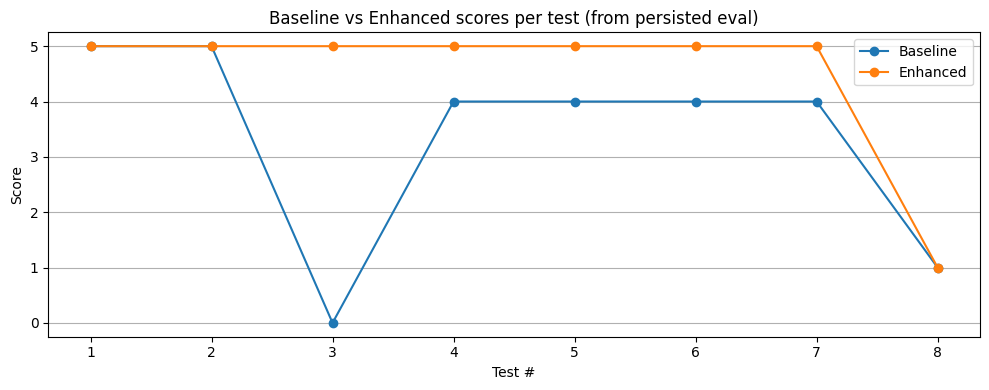

In [13]:
# cell 12 — Line chart using STORED evaluation scores (no recompute)

from pathlib import Path
import json, re
import pandas as pd
import matplotlib.pyplot as plt

runs_dir = Path("./selfrag_runs")

# Prefer explicit globals, else pick latest files
results_csv = Path(LAST_RESULTS_CSV) if 'LAST_RESULTS_CSV' in globals() and Path(LAST_RESULTS_CSV).exists() else None
results_json = Path(LAST_RESULTS_JSON) if 'LAST_RESULTS_JSON' in globals() and Path(LAST_RESULTS_JSON).exists() else None
if results_csv is None:
    cand_csv = sorted(runs_dir.glob("eval_results_*.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
    results_csv = cand_csv[0] if cand_csv else None
if results_json is None:
    cand_json = sorted(runs_dir.glob("eval_results_*.json"), key=lambda p: p.stat().st_mtime, reverse=True)
    results_json = cand_json[0] if cand_json else None

# Load persisted table
if results_csv is not None:
    df = pd.read_csv(results_csv)
    src = str(results_csv)
elif results_json is not None:
    with open(results_json, "r", encoding="utf-8") as f:
        payload = json.load(f)
    df = pd.DataFrame(payload.get("tests", []))
    src = str(results_json)
else:
    raise FileNotFoundError("No saved results found. Run cell 11 first.")

if "index" not in df.columns:
    df["index"] = range(1, len(df) + 1)
df = df.set_index("index")

def _to_int_series(x):
    return pd.to_numeric(x, errors="coerce").astype("Int64")

# Use stored evaluation scores if present, fallback to winner mapping
if {"eval_score_1", "eval_score_2"}.issubset(df.columns):
    baseline_score  = _to_int_series(df["eval_score_1"]).fillna(0)
    enhanced_score  = _to_int_series(df["eval_score_2"]).fillna(0)
else:
    baseline_score = pd.Series(0, index=df.index, dtype="Int64")
    enhanced_score = pd.Series(0, index=df.index, dtype="Int64")

if "eval_best" in df.columns:
    best = _to_int_series(df["eval_best"])
    fill = (baseline_score.isna() | (baseline_score == 0)) & (enhanced_score.isna() | (enhanced_score == 0))
    baseline_score = baseline_score.mask(fill & (best == 1), 1).fillna(0)
    enhanced_score = enhanced_score.mask(fill & (best == 2), 1).fillna(0)

plot_df = pd.DataFrame({
    "query": df.get("query", pd.Series(index=df.index, dtype=str)),
    "mode": df.get("mode", pd.Series(index=df.index, dtype=str)),
    "baseline_score": baseline_score.astype(int),
    "enhanced_score": enhanced_score.astype(int),
})

print("Loaded from:", src)
print(plot_df[["query", "mode", "baseline_score", "enhanced_score"]])

# Plot two lines
plt.figure(figsize=(10, 4))
plt.title("Baseline vs Enhanced scores per test (from persisted eval)")
plt.plot(plot_df.index, plot_df["baseline_score"], marker="o", label="Baseline")
plt.plot(plot_df.index, plot_df["enhanced_score"], marker="o", label="Enhanced")
plt.xlabel("Test #")
plt.ylabel("Score")
plt.xticks(plot_df.index, [str(i) for i in plot_df.index])
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()

# Keep paths for later reuse
EVAL_RESULTS_SRC = src
